<a href="https://colab.research.google.com/github/Pragna235/ACM-Winter-School-Assignment-4/blob/main/Assignment_4_Reddit_Data_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
# import tweepy as tw #for accessing Twitter API


#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *

# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#For data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# %matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data and Preprocess

In [2]:
# Load Reddit dataset
df = pd.read_csv('/content/Reddit_Data.csv')
# Output first five rows
df.head()

,clean_text,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [3]:
# dimensionality of the data
df.shape

(37249, 2)

In [4]:
# Check for missing data
df.isnull().sum()

clean_text    100
category        0
dtype: int64

In [5]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [6]:
# dimensionality of the data
df.shape

(37149, 2)

In [7]:
# Map tweet categories
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head()

,clean_text,category
0,family mormon have never tried explain them t...,Positive
1,buddhism has very much lot compatible with chr...,Positive
2,seriously don say thing first all they won get...,Negative
3,what you have learned yours and only yours wha...,Neutral
4,for your own benefit you may want read living ...,Positive


# Data Analysis

In [8]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

In [9]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

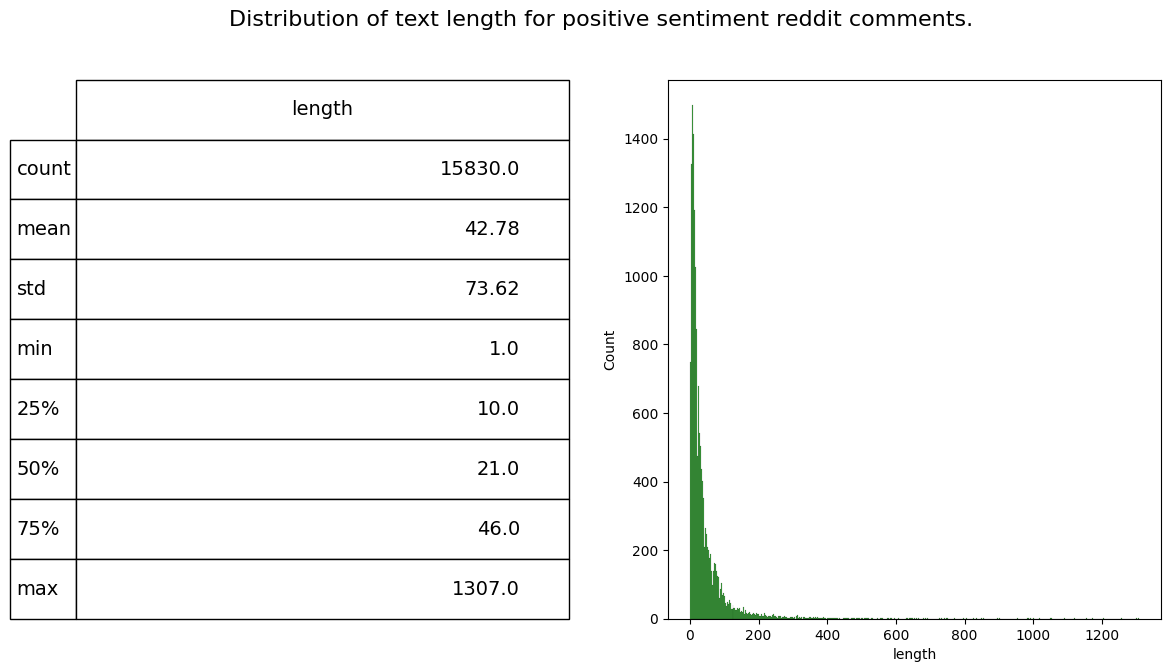

In [10]:
# Plotting the distribution of text length for positive sentiment tweets.
fig = plt.figure(figsize=(14,7))
# Add a new column 'length' to the DataFrame (df), which contains the number of words in each tweet after splitting the text.
df['length'] = df.clean_text.str.split().apply(len)
# Set up two subplots: one with subplot index 122 (right side) and another with subplot index 121 (left side).
ax1 = fig.add_subplot(122)
# Plot a histogram using seaborn (sns) for the lengths of tweets with positive sentiment ('Positive'). The histogram is shown on the subplot (ax1) with a green color.
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
# Calculate descriptive statistics (mean, std, min, 25%, 50%, 75%, max) for the lengths of positive sentiment reddit comments and rounds the values to two decimal places.
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

# Set up a table on the subplot (ax2) displaying the descriptive statistics for positive sentiment tweet lengths. The table is positioned to cover the entire subplot, and the font size is set to 14.
ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)

fig.suptitle('Distribution of text length for positive sentiment reddit comments.', fontsize=16)

plt.show()

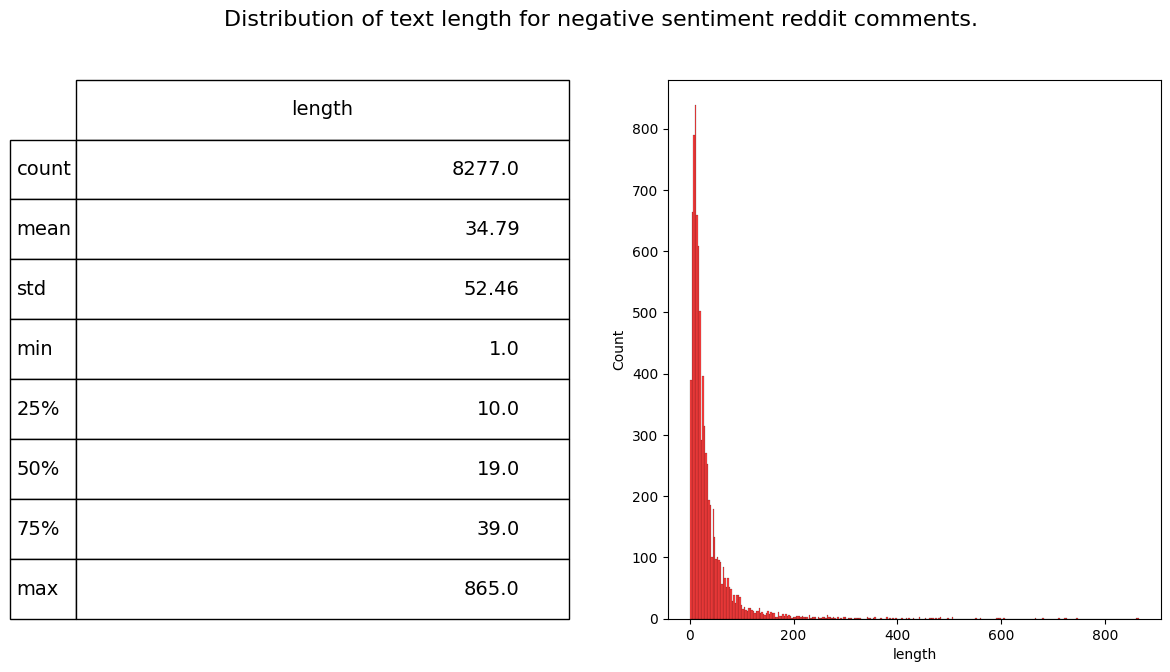

In [11]:
# Plotting the distribution of text length for negative sentiment reddit comments.
fig = plt.figure(figsize=(14,7))
# Add a new column 'length' to the DataFrame (df), which contains the number of words in each tweet after splitting the text.
df['length'] = df.clean_text.str.split().apply(len)
# Set up two subplots: one with subplot index 122 (right side) and another with subplot index 121 (left side).
ax1 = fig.add_subplot(122)
# Plot a histogram using seaborn (sns) for the lengths of tweets with positive sentiment ('Positive'). The histogram is shown on the subplot (ax1) with a green color.
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
# Calculate descriptive statistics (mean, std, min, 25%, 50%, 75%, max) for the lengths of positive sentiment tweets and rounds the values to two decimal places.
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

# Set up a table on the subplot (ax2) displaying the descriptive statistics for positive sentiment tweet lengths. The table is positioned to cover the entire subplot, and the font size is set to 14.
ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)

fig.suptitle('Distribution of text length for negative sentiment reddit comments.', fontsize=16)

plt.show()

In [12]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

In [13]:
df.head()

,clean_text,category,length
0,family mormon have never tried explain them t...,Positive,39
1,buddhism has very much lot compatible with chr...,Positive,196
2,seriously don say thing first all they won get...,Negative,86
3,what you have learned yours and only yours wha...,Neutral,29
4,for your own benefit you may want read living ...,Positive,112


In [14]:
df.drop(['length'], axis=1, inplace=True)
df.head()

,clean_text,category
0,family mormon have never tried explain them t...,Positive
1,buddhism has very much lot compatible with chr...,Positive
2,seriously don say thing first all they won get...,Negative
3,what you have learned yours and only yours wha...,Neutral
4,for your own benefit you may want read living ...,Positive


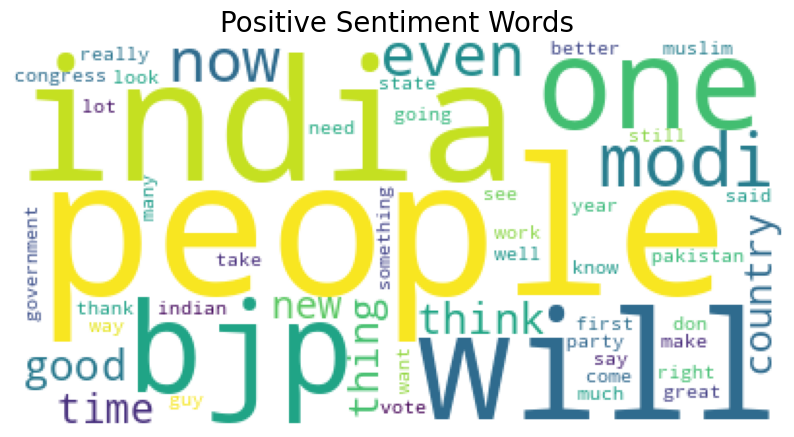

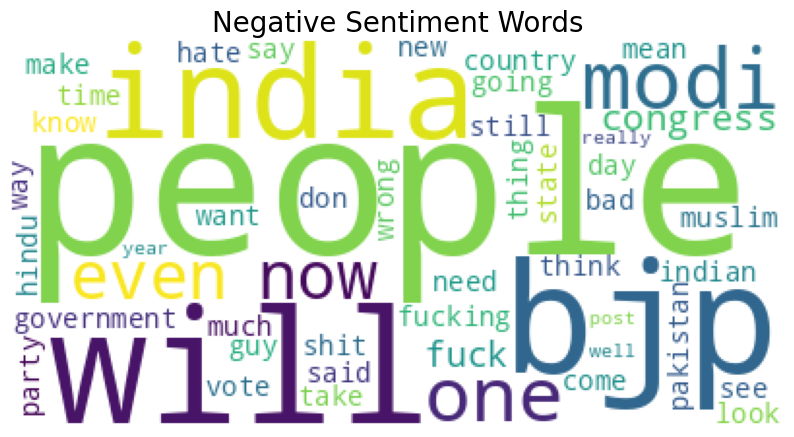

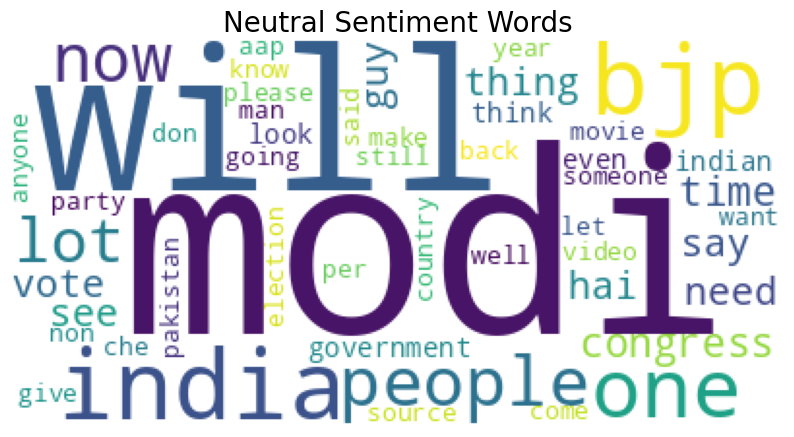

In [15]:
#### Visualizing data into wordclouds


from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    '''
    Generating Word Cloud
    inputs:
       - df: Reddit dataset
       - category: Positive/Negative/Neutral
    '''
    # Combine all tweets of the input category
    combined_reddit_comments = " ".join([reddit for reddit in df[df.category==category]['clean_text']])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_reddit_comments))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(df, 'Positive')

# Negative tweet words
wordcount_gen(df, 'Negative')

# Neutral tweet words
wordcount_gen(df, 'Neutral')


# Data Preprocessing


In [16]:
def reddit_to_words(reddit):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase
    text = reddit.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")] #Removes common English stopwords (e.g., "the," "and," "is") from the list of words. This step helps focus on more meaningful words for analysis.
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words] #Applies stemming using the Porter Stemmer algorithm to reduce words to their root or base form. Stemming helps consolidate variations of words into a common form.
    # return list
    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", reddit_to_words(df['clean_text'][0]))


Original tweet ->  family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches 

Processed tweet -> ['famili', 'mormon', 'never', 'tri', 'explain', 'still', 'stare', 'puzzl', 'time', 'time', 'like', 'kind', 'strang', 'creatur', 'nonetheless', 'come', 'admir', 'patienc', 'calm', 'equanim', 'accept', 'compass', 'develop', 'thing', 'buddhism', 'teach']


In [17]:
# Apply data processing to each tweet
X = list(map(reddit_to_words, df['clean_text']))
X

[['famili',
  'mormon',
  'never',
  'tri',
  'explain',
  'still',
  'stare',
  'puzzl',
  'time',
  'time',
  'like',
  'kind',
  'strang',
  'creatur',
  'nonetheless',
  'come',
  'admir',
  'patienc',
  'calm',
  'equanim',
  'accept',
  'compass',
  'develop',
  'thing',
  'buddhism',
  'teach'],
 ['buddhism',
  'much',
  'lot',
  'compat',
  'christian',
  'especi',
  'consid',
  'sin',
  'suffer',
  'almost',
  'thing',
  'suffer',
  'caus',
  'want',
  'thing',
  'want',
  'go',
  'get',
  'thing',
  'wrong',
  'way',
  'christian',
  'would',
  'mean',
  'want',
  'thing',
  'coincid',
  'god',
  'want',
  'thing',
  'coincid',
  'without',
  'aid',
  'jesu',
  'buddhism',
  'could',
  'also',
  'seen',
  'proof',
  'god',
  'mighti',
  'omnipot',
  'certainli',
  'christian',
  'lucki',
  'one',
  'christ',
  'side',
  'everyon',
  'els',
  'well',
  'mani',
  'christian',
  'believ',
  'god',
  'grace',
  'salvat',
  'buddhism',
  'god',
  'way',
  'show',
  'grace',
  'upo

In [18]:
print(len(X))

37149


In [19]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])

In [20]:
print(df['clean_text'][0])
print(X[0])
print(df['category'][0])
print(Y[0])

 family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches 
['famili', 'mormon', 'never', 'tri', 'explain', 'still', 'stare', 'puzzl', 'time', 'time', 'like', 'kind', 'strang', 'creatur', 'nonetheless', 'come', 'admir', 'patienc', 'calm', 'equanim', 'accept', 'compass', 'develop', 'thing', 'buddhism', 'teach']
Positive
2


# Tokenizing and Padding


In [42]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=200

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of integers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
  family mormon have never tried explain them they still stare puzzled from time time like some kind strange creature nonetheless they have come admire for the patience calmness equanimity acceptance and compassion have developed all the things buddhism teaches 
After Tokenization & Padding 
 [ 254   10  122  641  870   39    9   94   23   53   53   21   42  289
 4163    9   10  128 3148    5    1    2 4415   10 1438   18    1  111
 1517    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 

# Save Tokenized Data

In [43]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Train and Test Split

In [44]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(type(X_train),type(y_train))
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

<class 'numpy.ndarray'> <class 'pandas.core.frame.DataFrame'>
Train Set -> (22289, 200) (22289, 3)
Validation Set -> (7430, 200) (7430, 3)
Test Set -> (7430, 200) (7430, 3)


In [45]:
# import keras.backend as K

# def f1_score(precision, recall):
#     ''' Function to calculate f1 score '''

#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

# Model

In [46]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, SimpleRNN
# from keras.metrics import Precision, Recall
# from keras.optimizers import SGD
# from keras.optimizers import RMSprop
# from keras import datasets

# from keras.callbacks import LearningRateScheduler
# from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=10
learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8

# sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
# model= Sequential()
# model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(32)))
# model.add(Dropout(0.4))
# model.add(Dense(3, activation='softmax'))

model = Sequential()

model.add(Embedding(vocab_size,embedding_size,input_length =max_len)) # num_words=15000
model.add(SimpleRNN(16,input_shape = (vocab_size,max_len), return_sequences=False,activation="relu"))
model.add(Dense(3, activation='softmax'))



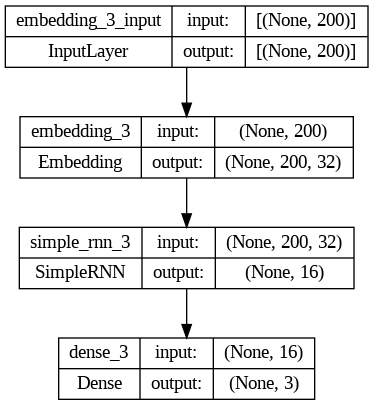

In [47]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [48]:
print(model.summary())


# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               metrics=['accuracy'])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 32)           160000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 160835 (628.26 KB)
Trainable params: 160835 (628.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
349/349 [==============================] - 17s 46ms/step - loss: nan - accuracy: 0.2272 - val_loss: nan - val_accuracy: 0.2192
Epoch 2/10
349/349 [==============================] - 16s 45ms/step - loss: nan - accuracy: 0.2245 - val_loss: nan - val_accuracy: 0.21

# Model and Accuracy Loss

In [49]:
# Evaluate model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print(score)

[nan, 0.22126513719558716]


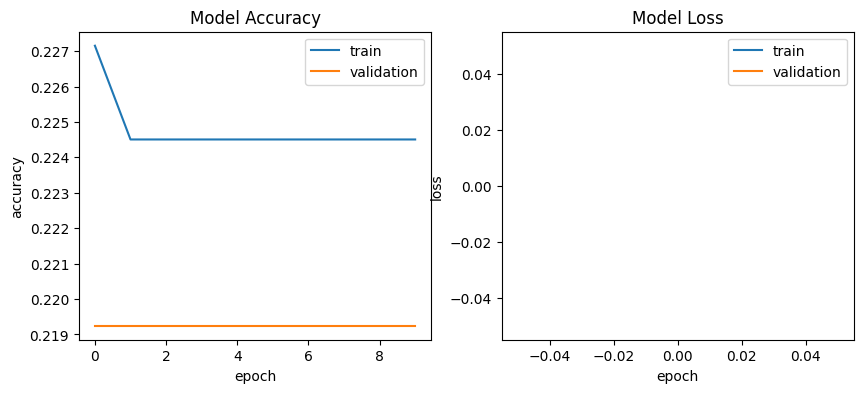

In [50]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

# LSTM

In [51]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, SimpleRNN
# from keras.metrics import Precision, Recall
# from keras.optimizers import SGD
# from keras.optimizers import RMSprop
# from keras import datasets

# from keras.callbacks import LearningRateScheduler
# from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=10
learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8

# sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
# model= Sequential()
# model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(32)))
# model.add(Dropout(0.4))
# model.add(Dense(3, activation='softmax'))

model = Sequential()

model.add(Embedding(vocab_size,embedding_size,input_length =max_len)) # num_words=15000
model.add(LSTM(16))
model.add(Dense(3, activation='softmax'))



In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [53]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               metrics=['accuracy'])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 163187 (637.45 KB)
Trainable params: 163187 (637.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
349/349 [==============================] - 36s 98ms/step - loss: 1.0687 - accuracy: 0.4150 - val_loss: 1.0614 - val_accuracy: 0.4288
Epoch 2/10
349/349 [==============================] - 26s 76ms/step - loss: 1.0673 - accuracy: 0.4179 - val_loss: 1.0606 - val_ac

# Model Accuracy

In [54]:
# Evaluate model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print(score)

[1.064327359199524, 0.4231494069099426]


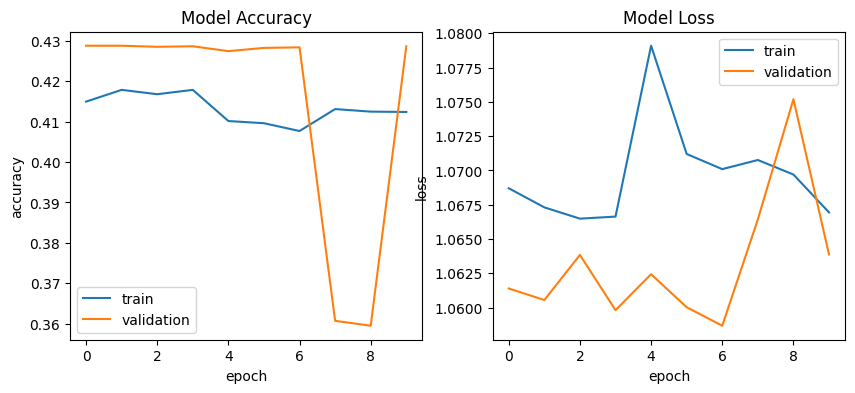

In [55]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

# GRU

In [56]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, SimpleRNN, GRU
# from keras.metrics import Precision, Recall
# from keras.optimizers import SGD
# from keras.optimizers import RMSprop
# from keras import datasets

# from keras.callbacks import LearningRateScheduler
# from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=10
learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8

# sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
# model= Sequential()
# model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Bidirectional(LSTM(32)))
# model.add(Dropout(0.4))
# model.add(Dense(3, activation='softmax'))

model = Sequential()

model.add(Embedding(vocab_size,embedding_size,input_length =max_len)) # num_words=15000
model.add(GRU(16))
model.add(Dense(3, activation='softmax'))



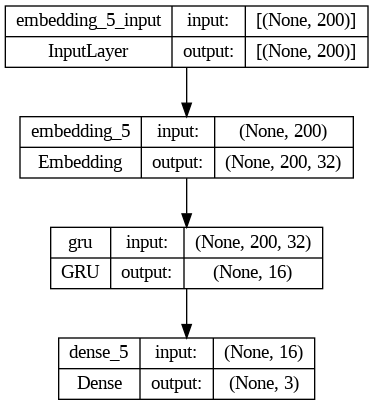

In [57]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [58]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
               metrics=['accuracy'])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 32)           160000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 162451 (634.57 KB)
Trainable params: 162451 (634.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
349/349 [==============================] - 33s 87ms/step - loss: 0.8966 - accuracy: 0.5972 - val_loss: 0.7356 - val_accuracy: 0.6917
Epoch 2/10
349/349 [==============================] - 29s 82ms/step - loss: 0.7335 - accuracy: 0.7001 - val_loss: 0.7276 - val_ac

# Model Accuracy

In [59]:
# Evaluate model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print(score)

[0.814037024974823, 0.6835801005363464]


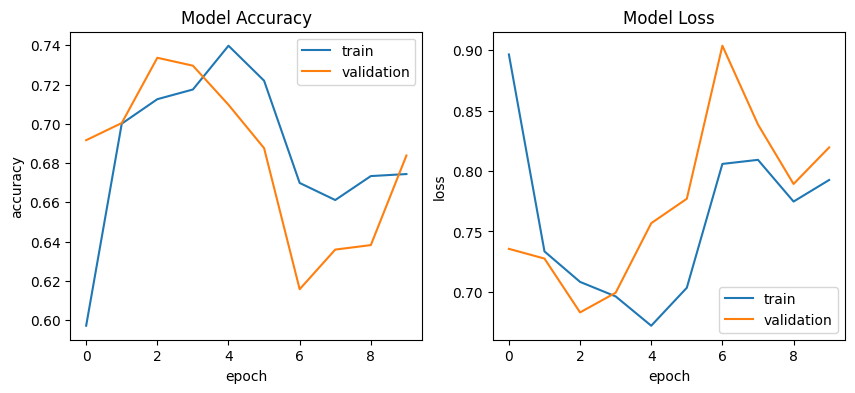

In [60]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)